In [1]:
from IPython.display import HTML
from IPython.display import display

# Taken from https://stackoverflow.com/questions/31517194/how-to-hide-one-specific-cell-input-or-output-in-ipython-notebook
tag = HTML('''<script>
code_show=true; 
function code_toggle() {
    if (code_show){
        $('div.cell.code_cell.rendered.selected div.input').hide();
    } else {
        $('div.cell.code_cell.rendered.selected div.input').show();
    }
    code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
Some hidden code... to show/hide this cell's raw code input, click (or double click if stubborn!) <a href="javascript:code_toggle()">here</a>.''')
display(tag)

############### Write code below ##################
from IPython.core.display import HTML
def css_styling():
    styles = open("./ES_ML_SOSSO/colors.css", "r").read()
    return HTML(styles)
css_styling()

# PX914: Workshop 8
## Machine Learning for Drug Discovery

In this workshop, we are going to use a Gaussian process to build a machine learning model for the solubility of a molecular dataset. The solubility of a given substance is a measure of the extent to which it dissolves in a solvent - typically water. Despite the fact that solubility is a solid-state property (you dissolve your ibuprofene pill in water, not a single molecule of ibuprofene...) up to now the field has been trying to make predictions based on the structure of single molecules in vacuum. We are breaking new ground in our research group, but that's a story for another day ([have a look here](https://pubs.rsc.org/en/content/articlelanding/2020/me/c9me00109c#!divAbstract)...)

<img src="./ES_ML_SOSSO/TOC.png">

Similarly to what you have done in "Assignment 5 - Gaussian Process regression for fitting interatomic potentials", we are going to harness GPs once more - this time, though, we'll have to think about molecular descriptors...

<div class=warn>
These blue boxes contain instructions for you to follow, or stuff for you to do.
<div/>    

<br>   
    
<b> Remember: </b> Make a copy of this Notebook! <br>
<div/>

We'll start off by loading a bunch of packages. You have already encountered the very convenient scikit-learn; as this is about chemistry(-ish...) we are going to leverage the RDKit package, which give you access to a number of descriptors specifically design to deal with molecules. 

In [26]:
%%capture
from __future__ import division

import pandas as pd
import numpy as np 
import ES_ML_SOSSO.chemfun as cf
from numpy.linalg import eigvalsh,eigh

from rdkit import Chem # rdkit contains a number of molecular descriptors
from rdkit.Chem.rdmolops import GetAdjacencyMatrix
from rdkit.Chem import AllChem
from rdkit.Chem.Crippen import MolLogP,MolMR

from sklearn.gaussian_process import GaussianProcessRegressor 
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.gaussian_process.kernels import Matern, WhiteKernel

import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from numpy import linalg as LA
% matplotlib inline
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole #Needed to show molecules
from rdkit.Chem.Draw.MolDrawing import MolDrawing, DrawingOptions # Only needed if modifying defaults
DrawingOptions.bondLineWidth=1.8

##  The dataset
The dataset we are going to use can be downloaded for free at http://moleculenet.ai/datasets-1. It contains the solubility in $\log[\text{mols/litre}]$ of (1128) common organic small molecules in water.

In [27]:
data=pd.read_table("./ES_ML_SOSSO/dataset.dat",header=None)

In [28]:
# Let's have a look at our dataset
data

,0,1
0,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...,-0.770
1,Cc1occc1C(=O)Nc2ccccc2,-3.300
2,CC(C)=CCCC(C)=CC(=O),-2.060
3,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43,-7.870
4,c1ccsc1,-1.330
...,...,...
1123,FC(F)(F)C(Cl)Br,-1.710
1124,CNC(=O)ON=C(SC)C(=O)N(C)C,0.106
1125,CCSCCSP(=S)(OC)OC,-3.091
1126,CCC(C)C,-3.180


## The SMILES format
Our database contains 1128 lines, one line / molecule. In each line, we have the structure of the molecule (1st column) and its solubility (2nd column). The structure is encoded in the so-called [SMILES format](https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system), which contains a limited amount of information about the structure - chiefly the identity of the atoms and their connectivity (i.e. which bonds are helding them together). A SMILES structure is thus 2D representation of a molecule - let's have a look...

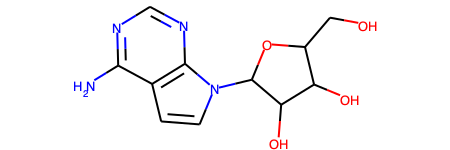

In [31]:
from rdkit.Chem.Draw import IPythonConsole #Needed to show molecules

smiles=data[0].values
logS=data[1].values

# Draw the structure 
test_mol=Chem.MolFromSmiles(smiles[150])

# Visualize the structure
test_mol

<div class=warn>
Add hydrogen atoms to the structure of the last molecule within the dataset and visualize the result. Have a look
<div/>

[here](https://www.rdkit.org/docs/GettingStartedInPython.html)

In [17]:
# Setting indices to know how data is split 
indices=np.arange(len(smiles))

In [32]:
# Load saved train/test sets...
# Feel free to create your own train/test splits...
Train=np.load('./ES_ML_SOSSO/Train.npy',allow_pickle = True)
Test=np.load('./ES_ML_SOSSO/Test.npy',allow_pickle = True)
TrainTargets=np.load('./ES_ML_SOSSO/TrainTargets.npy',allow_pickle = True)
TestTargets=np.load('./ES_ML_SOSSO/TestTargets.npy',allow_pickle = True)

In [33]:
# Convert into a different format (rdkit internal)
MFSTR=cf.SMILES2MOLES(Train)
MFSTE=cf.SMILES2MOLES(Test)

In [35]:
# Choosing the descriptors for training (SDTR) and test (SDTE) sets. 
from rdkit.Chem import Descriptors

In [36]:
SDTR=[]
for m in MFSTR:
    desc=[]
    desc.append(Chem.Lipinski.NumAromaticRings(m)) # Number of aromatic rings
    desc.append(Chem.Lipinski.NumHAcceptors(m))    # Number of hydrogen bond acceptors
    desc.append(Chem.Lipinski.HeavyAtomCount(m))   # Number of heavy atoms within the molecule
    desc.append(Descriptors.TPSA(m))               # from J. Med. Chem. 43:3714-7, (2000)
    SDTR.append(desc)
  
    
SDTE=[]
for m in MFSTE:
    desc=[]
    desc.append(Chem.Lipinski.NumAromaticRings(m)) 
    desc.append(Chem.Lipinski.NumHAcceptors(m))
    desc.append(Chem.Lipinski.HeavyAtomCount(m))
    desc.append(Descriptors.TPSA(m))
    SDTE.append(desc)

<div class=warn>

* Modify the list of descriptors using rdkit built-in descriptors (a list can be found [here](http://www.rdkit.org/docs/GettingStartedInPython.html#list-of-available-descriptors))<br>
* Motivate your choice (in a Markdown cell)

<div/>

In [37]:
# Use a Gaussian process (GP) to fit our training set

# Choosing the kernel: radial basis function, initial lengthscale =1

kernel=RBF(length_scale_bounds=(5e-02,10)) 

gp=GaussianProcessRegressor(kernel=kernel,normalize_y=True,n_restarts_optimizer=10,alpha=1e-4);

# Fit our GP model
gp.fit(SDTR,TrainTargets);

In [23]:
# Use the trained GP to predict the solubility of our training set...
TrainPred=gp.predict(SDTR).reshape(-1,1)
# ... and of our test set
TestPred=gp.predict(SDTE).reshape(-1,1)
# The reshape(-1,1) bit is needed to convert numpy arrays into scikit-learn compatible inputs...

In [24]:
from sklearn.metrics import mean_squared_error

# How are we doing? 
# Let us calculate the mean squared error of our prediction for the training set 
# with respect to the actual solubility values
mse_train=mean_squared_error(TrainTargets,TrainPred)
print("MSE (training)) = ", mse_train)

# Now let's do the same for the test set...
mse_test=mean_squared_error(TestTargets,TestPred)
print("MSE (test)) = ", mse_test)

MSE (training)) =  0.11318504376767921
MSE (test)) =  1.3858672651133017


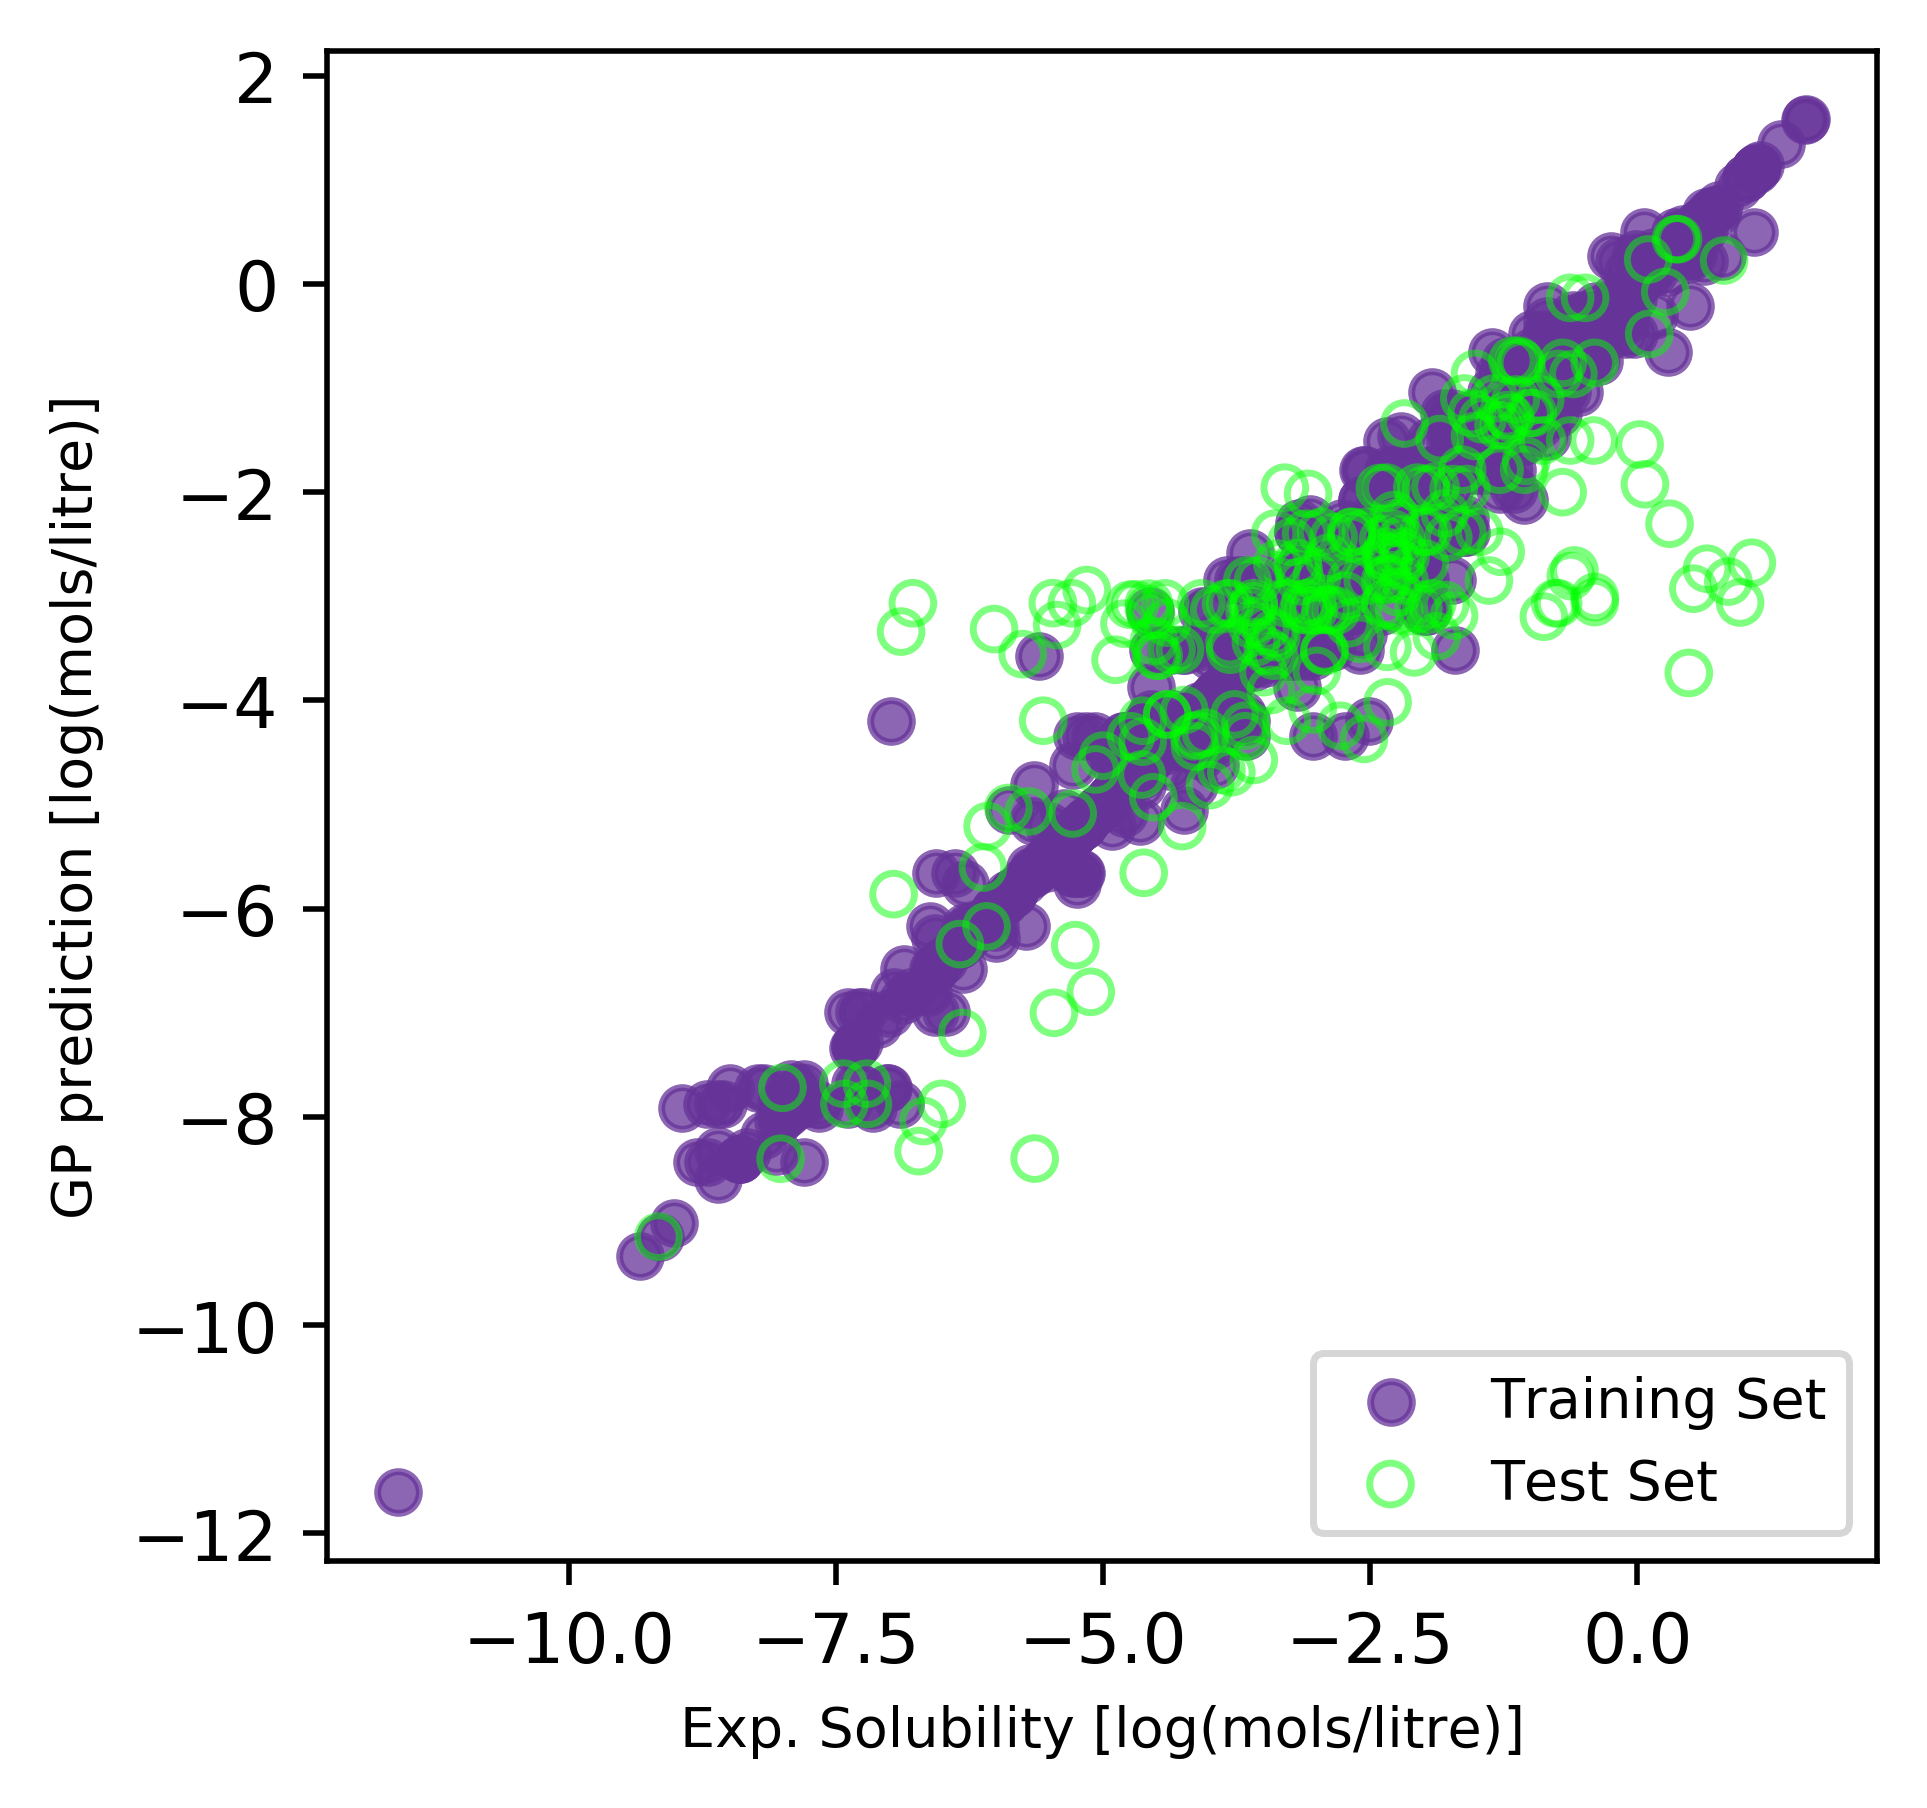

In [25]:
# Let's have a look!
fig=plt.figure(num=None,figsize=(4,4),dpi=500,facecolor='w',edgecolor='k')
plt.xlabel('Exp. Solubility [log(mols/litre)]',fontsize=8)
plt.ylabel('GP prediction [log(mols/litre)]',fontsize=8)
plt.scatter(TrainTargets,TrainPred,color='rebeccapurple',alpha=0.75,label='Training Set')
plt.scatter(TestTargets,TestPred,color='lime',alpha=0.5,label='Test Set',facecolors='none')
plt.legend(fontsize=8,loc=4);
#plt.savefig('4.png');

<div class=warn>
<h2>Over to you, folks!</h2>
    <i>If you don't know it... Google it!</i>
    
* <b>Step 1 [5%]</b>: Import the "FreeSolv" dataset from [http://moleculenet.ai/datasets-1] (a copy can also be found as "FreeSolv.csv" in the "ES_ML_SOSSO" directory within the Jupyter Notebook environment). <br>
* <b>Step 2 [5%]</b>: Split the dataset, by (randomly!) assigning 70% of the structure to the trainining set and 30% to the test set.<br>
* <b>Step 3 [5%]</b>: Plot the probability density function of the target values for both the training and the test dataset. <br>
* <b>Step 4 [10%]</b>: Choose your descriptors! <br>
* <b>Step 5 [25%]</b>: Fit a Gaussian Process using a [rational quadratic kernel](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.RationalQuadratic.html#sklearn.gaussian_process.kernels.RationalQuadratic), setting the initial value of the lengthscale to 1 and the initial value of the hyperparameter $\alpha$ to 0.1 in combination with a white kernel (setting the initial value of the noise level to 1). <br>
* <b>Step 6 [10%]</b>: Visualize the result via a scatter plot (GP prediction vs Exp. Lipophilicity) including training and test sets predictions.<br>
* <b>Step 7 [15%]</b>: Optimize the value of $\alpha$ according to the mean squared error of the predictions for the dataset. Depending on your specific settings, you might see very little variation in your MSE scores with different values of $\alpha$. If that is the case, feel free to explore any other aspect of the algorithm instead. Examples would include: using different kernels ([here is a readily accessible list](https://scikit-learn.org/stable/modules/gaussian_process.html#gp-kernels), but you can create your own as well) and/or exploring the effect of different optimizers. The [GridSearchCV function of scikit-learn](https://scikit-learn.org/stable/modules/grid_search.html) can speed up things greatly (if you master its usage...).<br>
* <b>Step 8 [5%]</b>: Visualize the (hopefully improved with respect to what you have obtained in Step 6) result via a scatter plot (GP prediction vs Exp. Lipophilicity) including training and test sets predictions.<br>   
* <b>Step 9 [10%]</b>: Calculate the mean square error and the Person's correlation coefficient relative to your prediction. Error bars can be added via [cross validation](https://scikit-learn.org/stable/modules/cross_validation.html).
<div/>